In [1]:
# import
from matplotlib import pyplot as plt
from nptdms import TdmsFile # https://nptdms.readthedocs.io/en/stable/
import numpy as np
from scipy import signal
import scipy.optimize
import functools
%matplotlib widget

In [2]:
# read in the correct tdms file
file = TdmsFile.read("Mike3_Transparency.tdms")

In [3]:
# extract the important measurements (use position encoder position derivative as velocity)
position = file["Transparency"]["Position [deg]"][:]
velocity = file["Transparency"]["Velocity encoder LP"][:]
torque = file["Transparency"]["Force [N]"][:] * 0.07 #the force is turned into the user torque by assuming a leverarm of 7cm.
time = (file["Transparency"]["Time"][:] - file["Transparency"]["Time"][0])*0.001

In [4]:
# delete all measurements where the measured time difference is zero
position = position[np.nonzero(np.diff(time))]
velocity = velocity[np.nonzero(np.diff(time))]
torque = torque[np.nonzero(np.diff(time))]
time = time[np.nonzero(np.diff(time))]

In [5]:
# filtering with a butterworth filter wih cutoff frequecy 20Hz (same as in "Interaction Control Strategies and Sensorimotor Task Design for the Assessment Robot ETH MIKE")
fs = 1/(time[1000]-time[999])
fc = 20

b,a = signal.butter(1,fc/(fs/2),'low')
pos_filt = signal.filtfilt(b,a,position)
vel_filt = signal.filtfilt(b,a,velocity)
tor_filt = signal.filtfilt(b,a,torque)

In [6]:
# calculate and filter the acceleration from the velocity signal
acc = np.diff(vel_filt)/np.diff(time)
acc_filt = signal.filtfilt(b,a,acc)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
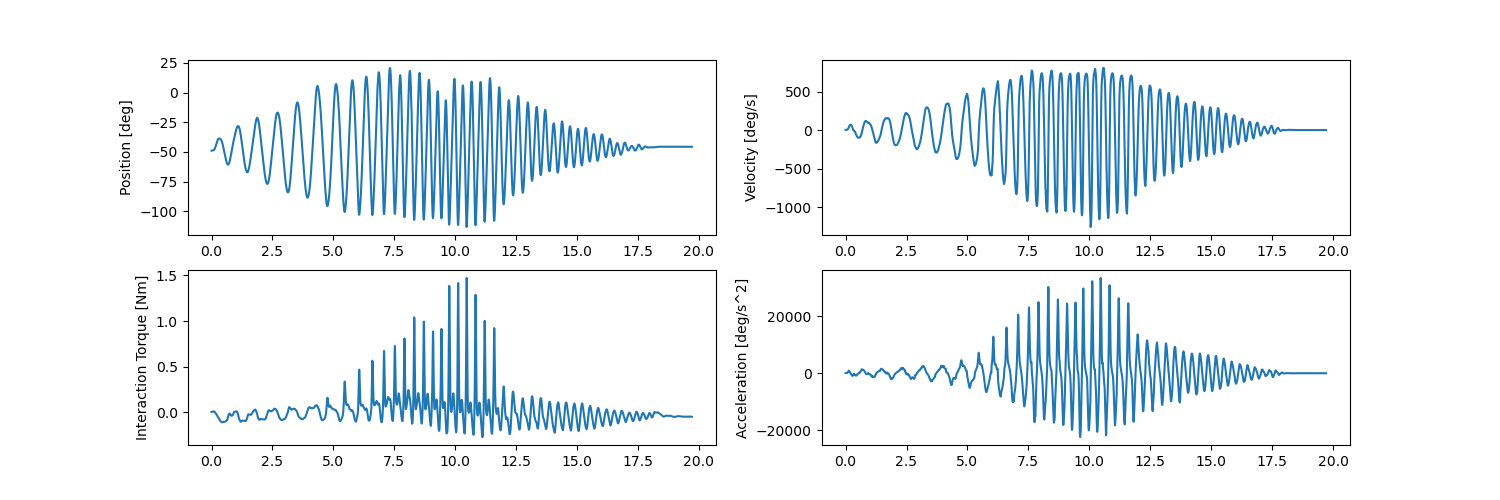

In [7]:
# plot the filtered signals (is only used for the verification of usability of recorded signals)
plt.close('all')
fig1, ax1 = plt.subplots(2,2)
fig1.set_size_inches(15,5)
ax1[0,0].plot(time,pos_filt)
ax1[0,0].set_ylabel("Position [deg]")
ax1[0,1].plot(time,vel_filt)
ax1[0,1].set_ylabel("Velocity [deg/s]")
ax1[1,0].plot(time,tor_filt)
ax1[1,0].set_ylabel("Interaction Torque [Nm]")
ax1[1,1].plot(time[0:len(time)-1],acc_filt)
ax1[1,1].set_ylabel("Acceleration [deg/s^2]")
plt.show(fig1)

In [8]:
# plane: calculate z value of plane in the form z = a*x + b*y, where params is [a,b], this equals our equation tau = b*velocity + i*acceleration
def plane(x,y,params):
    b = params[0]
    i = params[1]
    z = b*x + i*y
    return z

# error: calculate the error between measured points and points on our approximated plane, will later be used as minimizing function to calculate the plane
def error(params, points):
    result = 0
    for (x,y,z) in points:
        plane_z = plane(x,y,params)
        diff = abs(plane_z-z)
        result += diff**2
    return result

In [9]:
# create 3d-points from collected data
points = []
for i in range(0,len(acc)):
    points.append((vel_filt[i], acc_filt[i], tor_filt[i]))

In [10]:
# calculate the fitted plane by minimizing our error function
fun = functools.partial(error, points=points)
params0 = [0,0]
res = scipy.optimize.minimize(fun, params0)

b = res.x[0]
i = res.x[1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
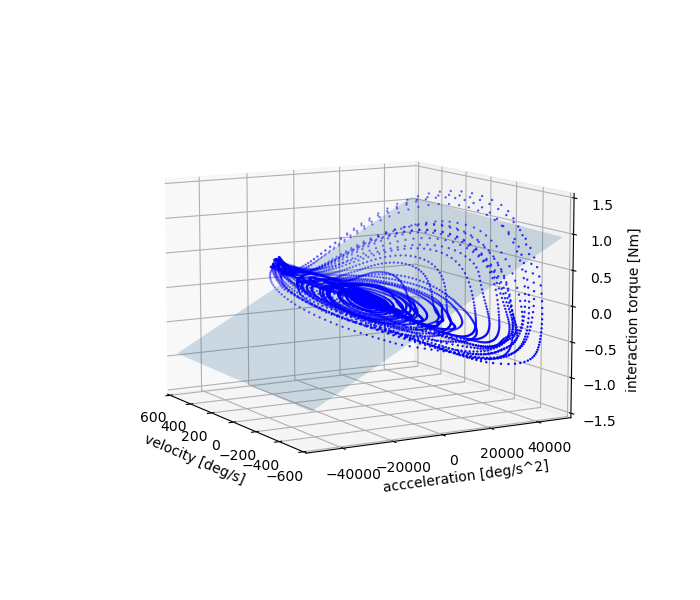

In [14]:
# plotting
plt.close('all')
fig = plt.figure()
fig.set_size_inches(7,6)
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(vel_filt[0:len(acc)], acc_filt, tor_filt[0:len(acc)], s=0.5, c='b')

xx, yy = np.meshgrid([-600,600], [-51000,51000])

z = b*xx+i*yy
     
ax.plot_surface(xx,yy,z,alpha=0.2)
ax.view_init(10, 150)

ax.set_xlabel("velocity [deg/s]")
ax.set_ylabel("accceleration [deg/s^2]")
ax.set_zlabel("interaction torque [Nm]")

ax.set_zlim([-1.5,1.5])
ax.set_xlim([-600,600])
ax.set_ylim([-52000,52000])

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

plt.savefig("Mike3_Transparency.pdf", bbox_inches='tight')
plt.show(fig)

In [12]:
# calculate z residuals
residuals = np.zeros(len(acc_filt))
for j in range(0,len(acc_filt)):
    residuals[j] = abs(tor_filt[j]-plane(vel_filt[j], acc_filt[j], [b,i]))
max_residual = max(residuals)
avg_residual = np.mean(residuals)

In [13]:
# print out the results
i_app = i*1000
b_app = b*1000
print("The apparent inertia is i_app =", i_app, "(g*m^2)/deg")
print("The apparent damping is b_app =", b_app, "mNm/(deg/s)")
print("The average residual is r_avg =", avg_residual, "Nm")
print("The maximum residual is r_max =", max_residual ,"Nm")

The apparent inertia is i_app = 0.019617341963042777 (g*m^2)/deg
The apparent damping is b_app = 0.06923433976857406 mNm/(deg/s)
The average residual is r_avg = 0.07964482471320895 Nm
The maximum residual is r_max = 0.8534869366507211 Nm
